<a href="https://colab.research.google.com/github/asdas1505/VAE-Pytorch/blob/master/VAE_self.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
class VAE(nn.Module):

  def __init__(self, h1, h2, z):
    super(VAE, self).__init__()

    self.fc1_e = nn.Linear(784, h1)
    self.fc2_e = nn.Linear(h1, h2)
    self.fc3_e = nn.Linear(h2, z)
    self.fc4_e = nn.Linear(h2, z)

    self.fc1_d = nn.Linear(z, h2)
    self.fc2_d = nn.Linear(h2, h1)
    self.fc3_d = nn.Linear(h1, 784)

  def encoder(self, x):
    x = F.relu(self.fc1_e(x))
    x = F.relu(self.fc2_e(x))
    mu = self.fc3_e(x)
    log_var = self.fc4_e(x)
    return mu, log_var 

  def sampling(self, x):
    mu, log_var = self.encoder(x.view(-1,784))
    std = torch.exp(0.5*log_var)
    epsilon = torch.randn_like(std)
    return epsilon.mul(std).add_(mu), mu, log_var

  def decoder(self, z):
    z = F.relu(self.fc1_d(z))
    z = F.relu(self.fc2_d(z))
    x_cap = F.sigmoid(self.fc3_d(z))
    return x_cap

  def forward(self, x):
    z, mu, log_var = self.sampling(x)
    x_cap = self.decoder(z)
    return x_cap, mu, log_var

vae = VAE(h1=512, h2=256, z=2)
if torch.cuda.is_available():
    vae.cuda()

In [83]:
# !export CUDA_LAUNCH_BLOCKING=1

In [5]:
import torch.optim as optim
optimizer = optim.Adam(vae.parameters())

def loss_function(x, x_cap, mu, log_var):
  RCE = F.binary_cross_entropy(x_cap, x.view(-1, 784), reduction='sum')
  KLE = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return RCE + KLE

In [8]:
def train(epoch):
    vae.train()
    train_loss = 0
    for idx , (data, _) in enumerate(train_loader):
      data = data.cuda()
      optimizer.zero_grad()

      data_caps, mu, log_var = vae(data)
      loss = loss_function(data, data_caps, mu, log_var)

      loss.backward()
      train_loss = train_loss + loss.item()
      optimizer.step()
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    save_image(sample.view(64, 1, 28, 28), '/samples/sample_' + str(epoch) + '.png')
    print(('Epochs: ' + str(epoch) + ' ' + str(train_loss/len(train_loader.dataset)) ))

In [9]:
# Model Training 
for e in range(50):
  train(e)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epochs: 0 157.9086659342448
Epochs: 1 152.80618619791667
Epochs: 2 149.9386294921875
Epochs: 3 148.19605721028645
Epochs: 4 146.9370989908854
Epochs: 5 145.71394365234374
Epochs: 6 145.01860388997395
Epochs: 7 144.46063196614583
Epochs: 8 143.4370564453125
Epochs: 9 143.0285623046875
Epochs: 10 142.5486066731771
Epochs: 11 142.4352330891927
Epochs: 12 141.73038343098958
Epochs: 13 141.589900390625
Epochs: 14 140.92371248372396
Epochs: 15 140.55617076822918
Epochs: 16 140.2505890625
Epochs: 17 140.2932528483073
Epochs: 18 140.22472568359376
Epochs: 19 140.27245548502603
Epochs: 20 139.93424404296874
Epochs: 21 139.63679778645835
Epochs: 22 139.11248849283854
Epochs: 23 138.5365126139323
Epochs: 24 138.51252779947916
Epochs: 25 139.77333333333334
Epochs: 26 141.0621913248698
Epochs: 27 138.5630152018229
Epochs: 28 138.46807467447917
Epochs: 29 138.02275641276043
Epochs: 30 138.47525952148436
Epochs: 31 138.06111334635418
Epochs: 32 137.82528071289062
Epochs: 33 137.5864127766927
Epochs: 

In [12]:
plot_data = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20000, shuffle=True)
for idx, (data,labels) in enumerate(plot_data):
  print('x')
z_plot ,_  ,_ = vae.sampling(data.cuda())

x
x
x


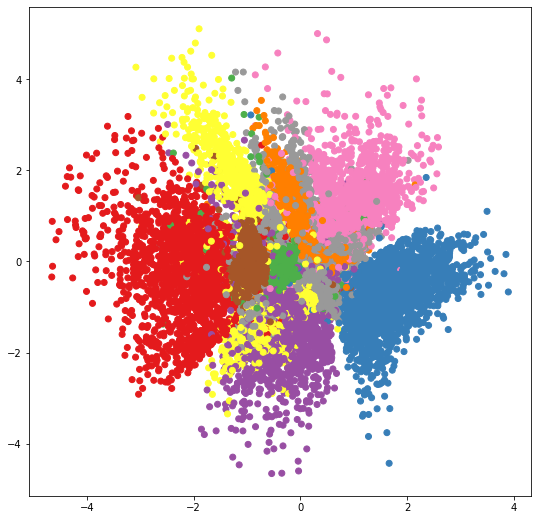

In [29]:
# Latent Representation of Numbers
# Each colour denotes one number in MNIST Dataset on latent space  

import matplotlib.pyplot as plt
plt.figure(figsize=(9,9))
plt.scatter(z_plot.detach().cpu().numpy()[:,0], z_plot.detach().cpu().numpy()[:,1],c = labels.detach().cpu().numpy(), cmap = 'Set1')

In [23]:
#  GIF showing improvement in reconstructed images as model trains.

import os 
from PIL import Image 

images_dir = '/samples'
image_list = []
for i in range(len(os.listdir(images_dir))):
  temp_img = Image.open(images_dir + '/sample_' + str(i) + '.png' )
  image_list.append(temp_img)

image_list[0].save('/samples/out.gif', save_all=True, append_images=image_list[1:])